<a href="https://colab.research.google.com/github/sophie55555/Quest/blob/main/p2_object_detection_2025_1_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드 살펴보기
해당 코드는 텐서플로우 공식 홈페이지의 튜토리얼에서 제시된 코드를 활용했습니다.

먼저 필요한 라이브러리를 불러옵니다.

In [ ]:
!pip3 install tensorflow-estimator==2.6.0

In [ ]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

이미지를 시각화하는 함수를 만들어 둡니다.

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

원하는 이미지를 다운로드하고 정해진 가로, 세로 길이에 맞게 이미지를 resizing하는 함수를 만들어둡니다.

In [ ]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

Bounding Box를 만드는 함수를 만듭니다.

In [ ]:
def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

이미지 위에 class 이름과 score를 나타내는 함수도 만듭니다.

In [ ]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

이미지를 불러옵니다.

원하는 이미지를 불러오고, 가로와 세로를 변경해 보는 실험을 진행해 보세요.

In [ ]:

pip install Pillow==9.5.0


tfhub에서 사전 학습된(Pre-trained) InceptionResnet 모델을 사용한 Faster RCNN 모델을 불러옵니다.

<ipython-input-5-aa2905205e73>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정


Image downloaded to /tmp/tmp_2hv3168.jpg.


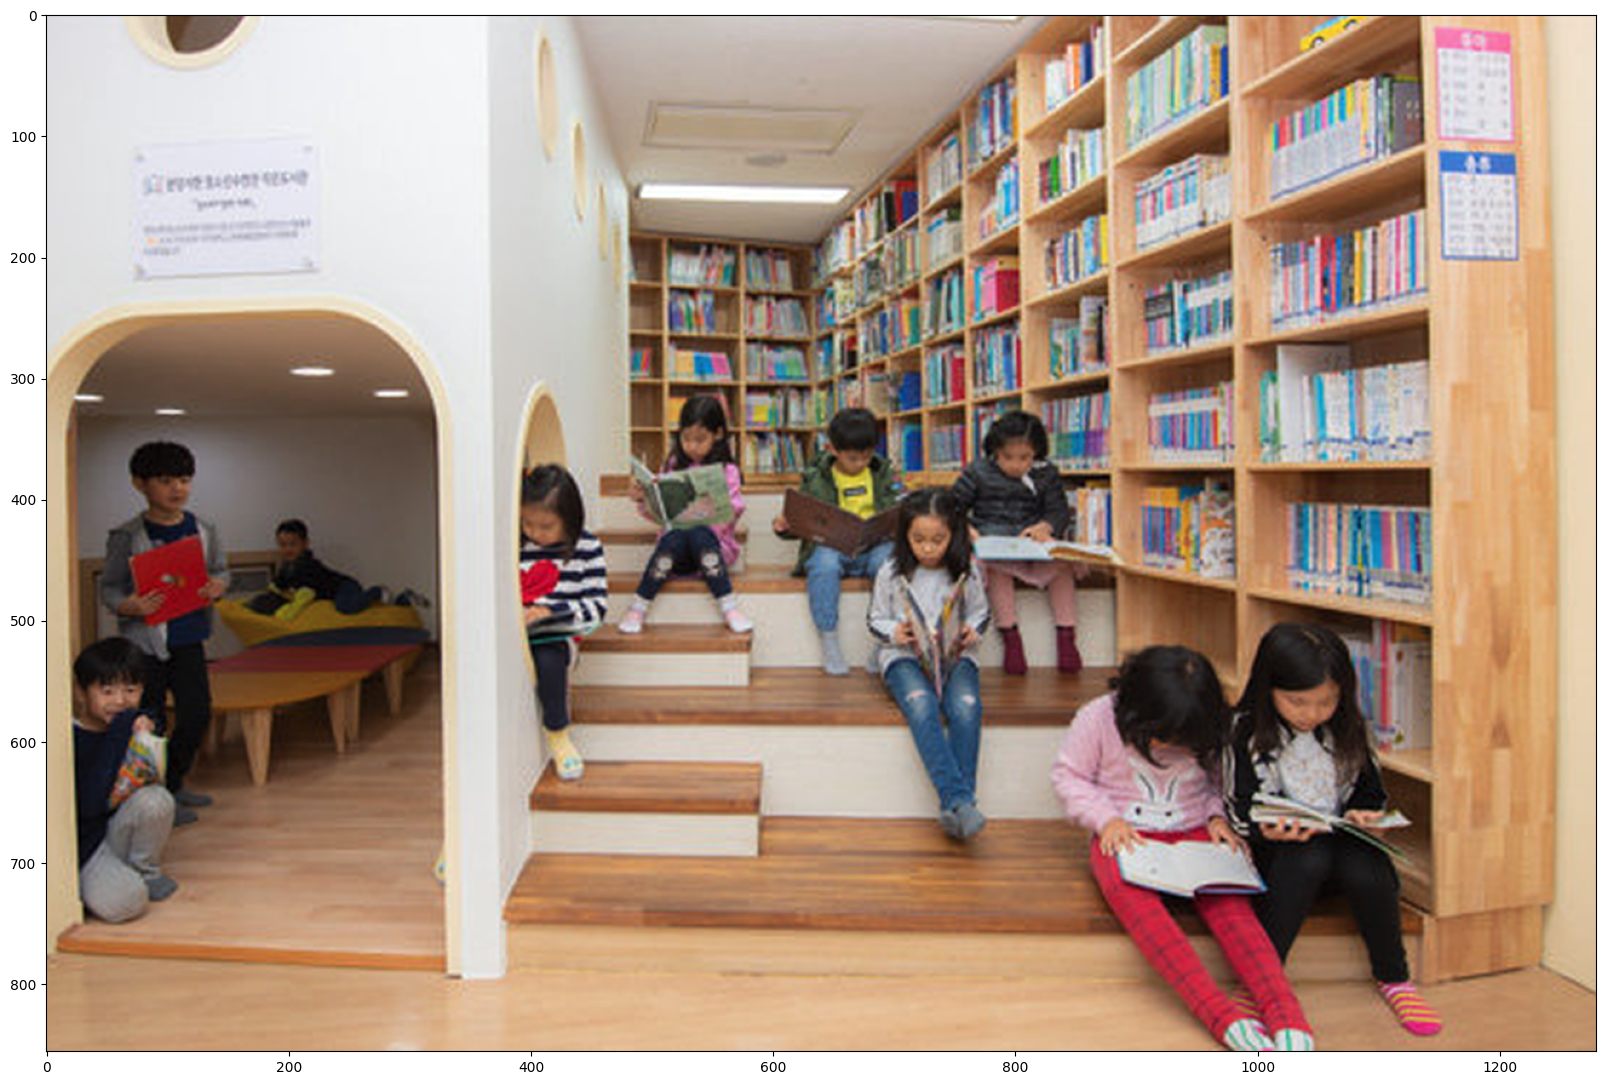

In [ ]:
from urllib.request import pathname2url

# 로컬 파일 경로 지정
image_path = '/content/drive/MyDrive/data/children.jpeg'

# 로컬 파일 경로를 URL로 변환
image_url = 'file://' + pathname2url(image_path)

# 이미지 다운로드 및 크기 조정 함수 호출
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)


In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Detector를 실행하는 함수를 만듭니다.

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

detector를 실행시켜 봅시다.

Found 100 objects.
Inference time:  91.14611458778381


<ipython-input-6-8b156eaed91c>:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-6-8b156eaed91c>:29: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


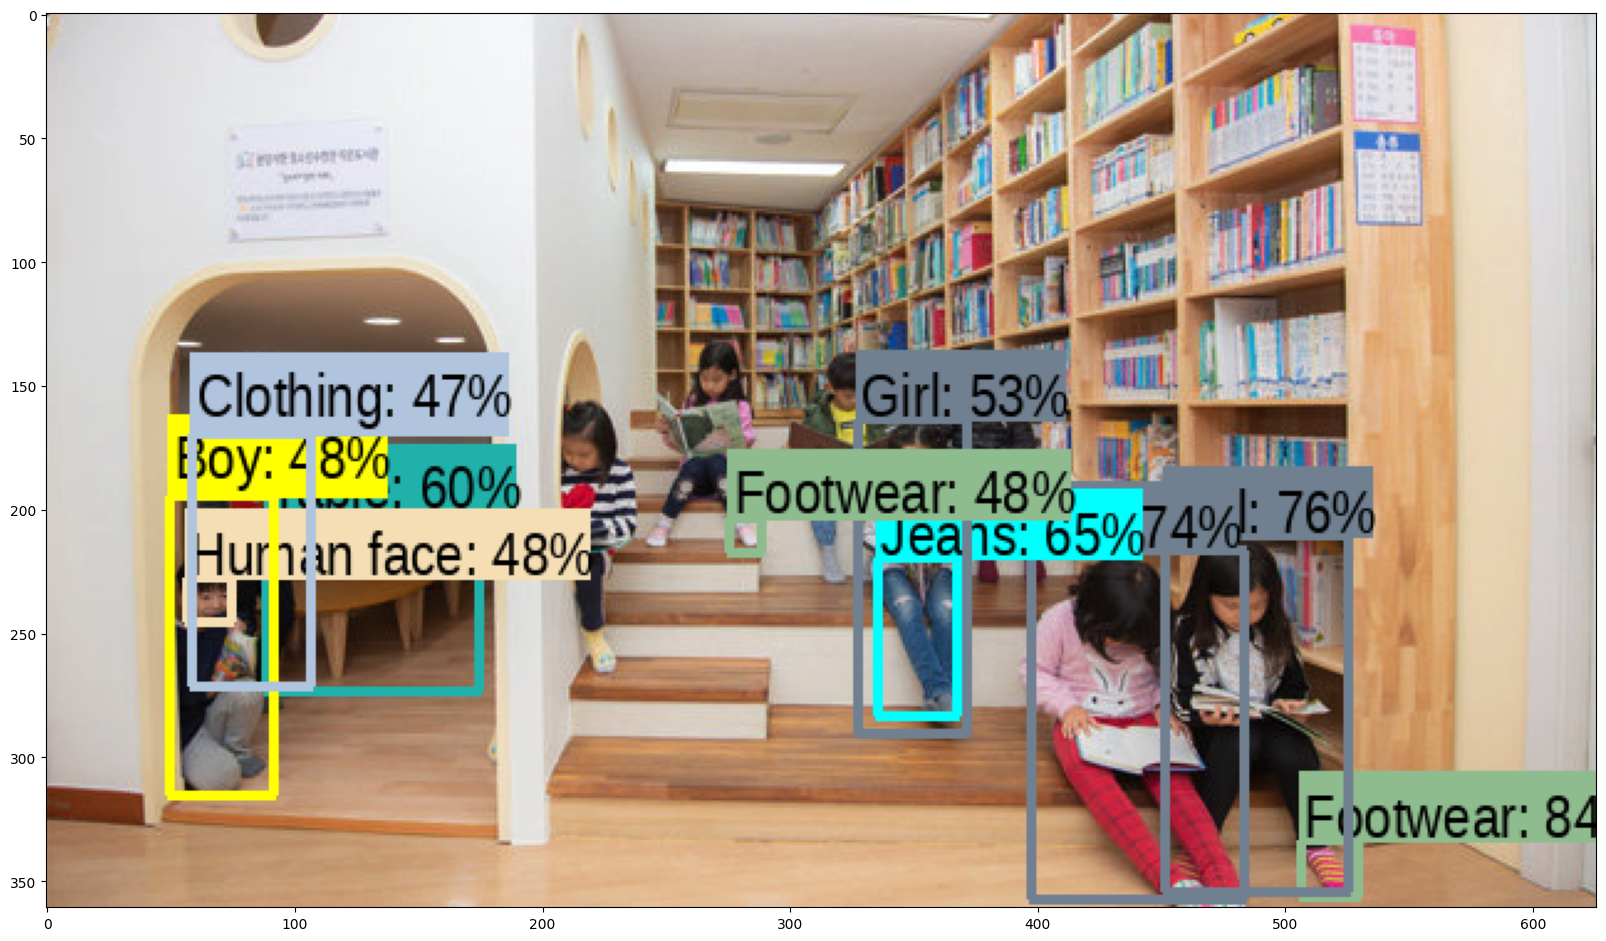

In [ ]:
run_detector(detector, image_path)

문제 2-2. 다양한 pre-trained model 테스트해보기
Faster RCNN 외에도 Object Detection을 할 수 있는 다양한 사전 학습 모델이 있습니다. tfhub을 탐색하여 사용할 수 있는 1개 이상의 모델을 불러와 결과를 테스트해보고, 그 결과를 비교해 보세요.

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Detector를 실행하는 함수를 만듭니다.

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

detector를 실행시켜 봅시다.

Found 100 objects.
Inference time:  13.248520135879517


<ipython-input-6-8b156eaed91c>:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-6-8b156eaed91c>:29: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


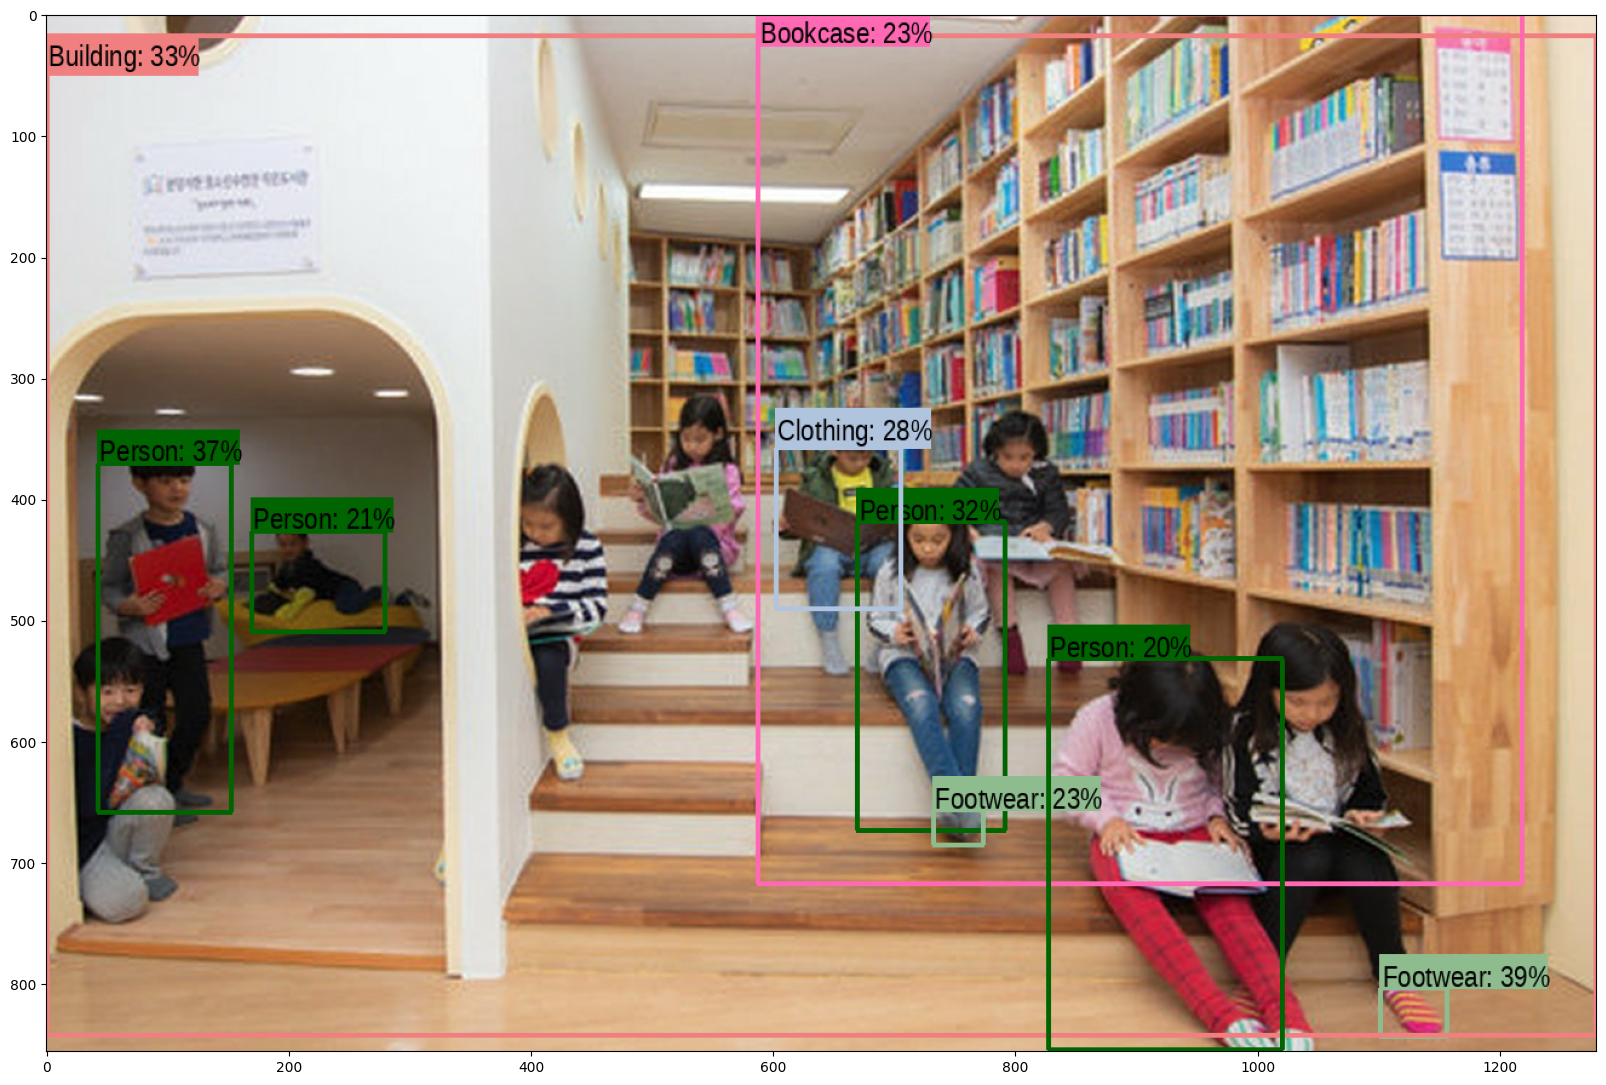

In [ ]:
run_detector(detector, downloaded_image_path)

모델 비교:

Faster R-CNN Inception ResNet V2 640x640:

Found 100 objects.
Inference time:  91.14611458778381

정확도: 높은 정확도를 제공하며, 특히 작은 객체 감지에 강점을 보입니다.

속도: 상대적으로 느린 추론 속도를 보이며, 실시간 처리에는 제한이 있을 수 있습니다.


SSD MobileNet V2:

Found 100 objects.
Inference time:  13.248520135879517

정확도: 상대적으로 낮은 정확도를 보이며, 작은 객체 감지에서 성능이 떨어질 수 있습니다.

속도: 빠른 추론 속도를 제공하여 실시간 처리에 적합합니다.